# Kenyan Food Classification Training Pipeline (Trainer Version)
This notebook demonstrates a modular neural network training pipeline using the scripts in the `trainer` folder.

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim


# Trainer imports
from trainer.trainer import Trainer
from trainer.metrics import AccuracyEstimator
from trainer.configuration import SystemConfig, DatasetConfig, DataloaderConfig, OptimizerConfig, TrainerConfig
from trainer.utils import setup_system, patch_configs

from trainer.data_loader import get_data_loaders
from trainer.model import get_model

from trainer.tensorboard_visualizer import TensorBoardVisualizer



In [2]:
# Visualizer (TensorBoard)
visualizer = TensorBoardVisualizer()

## Configuration
Set up all configuration objects for the pipeline.

In [3]:


system_config = SystemConfig()
setup_system(system_config)

# Patch configs for device
dataloader_config, trainer_config = patch_configs(epoch_num_to_set=80, 
                                                    batch_size_to_set=16)  # NO! WE NEED TO GET THE DATALOADER AS WELL

optimizer_config = OptimizerConfig()

Using MPS backend for PyTorch


## Import Loaders and Model
Import all the required components to start the training.

In [4]:
# Data loaders

#dataloader_config = DataloaderConfig()

train_loader, val_loader, num_classes = get_data_loaders(
    data_root="./data", 
    batch_size=dataloader_config.batch_size, 
    num_workers=dataloader_config.num_workers, 
    seed=system_config.seed, 
    data_augmentation=True,
    test_size=dataloader_config.test_size,
)

In [5]:
# Model
model = get_model(
    num_classes = num_classes,
    pretrained = True,
    freeze_backbone = True,
    trainable_layers = 2
) 

model = model.to(trainer_config.device)

# Save the model visualization
dummy_input = torch.randn(1, 3, 224, 224).to(trainer_config.device)
visualizer.add_model_graph(model, input_tensor=dummy_input)


/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:

# Optimizer, Scheduler
optimizer = optim.AdamW(model.parameters(), 
                        lr=optimizer_config.learning_rate,
                        #momentum=optimizer_config.momentum, 
                        weight_decay=optimizer_config.weight_decay)

scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                      step_size=optimizer_config.scheduler_step_size, 
                                      gamma=optimizer_config.scheduler_gamma)

In [7]:
# Loss and metric
loss_fn = nn.CrossEntropyLoss()
metric_fn = AccuracyEstimator(topk=(1,))

## Training
Run the Trainer pipeline.

In [8]:
trainer = Trainer(
    model=model,
    loader_train=train_loader,
    loader_test=val_loader,
    loss_fn=loss_fn,
    metric_fn=metric_fn,
    optimizer=optimizer,
    lr_scheduler=scheduler,
    device=trainer_config.device,
    model_saving_frequency=trainer_config.model_saving_frequency,
    save_dir=trainer_config.model_dir,
    model_name_prefix="kenyanfood_model",
    data_getter=lambda sample: sample["image"],
    target_getter=lambda sample: torch.tensor(sample["target"]),
    stage_progress=trainer_config.progress_bar,
    visualizer=visualizer,
    get_key_metric=lambda metric: metric["top1"]
)
metrics = trainer.fit(trainer_config.epoch_num)

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

/var/folders/d7/0p6dzffs5j925l53xdynmh3r0000gp/T/ipykernel_2374/3902183635.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_getter=lambda sample: torch.tensor(sample["target"]),


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:999: The handshake operation timed out>
  data = fetch_version_info()
/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:999: The handshake operation timed out>
  data = fetch_version_info()


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:999: The handshake operation timed out>
  data = fetch_version_info()
/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:999: The handshake operation timed out>
  data = fetch_version_info()
/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info The read operation timed out
  data = fetch_version_info()
/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info The read operation timed out
  data = fetch_version_info()
/Users

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info The read operation timed out
  data = fetch_version_info()


  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info The read operation timed out
  data = fetch_version_info()
/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info The read operation timed out
  data = fetch_version_info()


  0%|          | 0/327 [00:00<?, ?it/s]

/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:999: The handshake operation timed out>
  data = fetch_version_info()
/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:999: The handshake operation timed out>
  data = fetch_version_info()
/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:999: The handshake operation timed out>
  data = fetch_version_info()


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info The read operation timed out
  data = fetch_version_info()
/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info The read operation timed out
  data = fetch_version_info()
/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:999: The handshake operation timed out>
  data = fetch_version_info()


  0%|          | 0/327 [00:00<?, ?it/s]

/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:999: The handshake operation timed out>
  data = fetch_version_info()
/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:999: The handshake operation timed out>
  data = fetch_version_info()
/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info The read operation timed out
  data = fetch_version_info()


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [02:30<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info The read operation timed out
  data = fetch_version_info()
/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info The read operation timed out
  data = fetch_version_info()


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info The read operation timed out
  data = fetch_version_info()
/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:999: The handshake operation timed out>
  data = fetch_version_info()
/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info The read operation timed out
  data = fetch_version_info()
/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info The read operation timed out
  data = fetch_version_info()
/Users/gabriele.gabrielli/Documents-per

  0%|          | 0/82 [00:00<?, ?it/s]

/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info The read operation timed out
  data = fetch_version_info()
/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info The read operation timed out
  data = fetch_version_info()


  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlo

  0%|          | 0/327 [00:00<?, ?it/s]

/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/gabriele.gabrielli/Documents-personal/opencv_pytorch/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlo

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

In [9]:
# Close TensorBoard writer
visualizer.close_tensorboard()

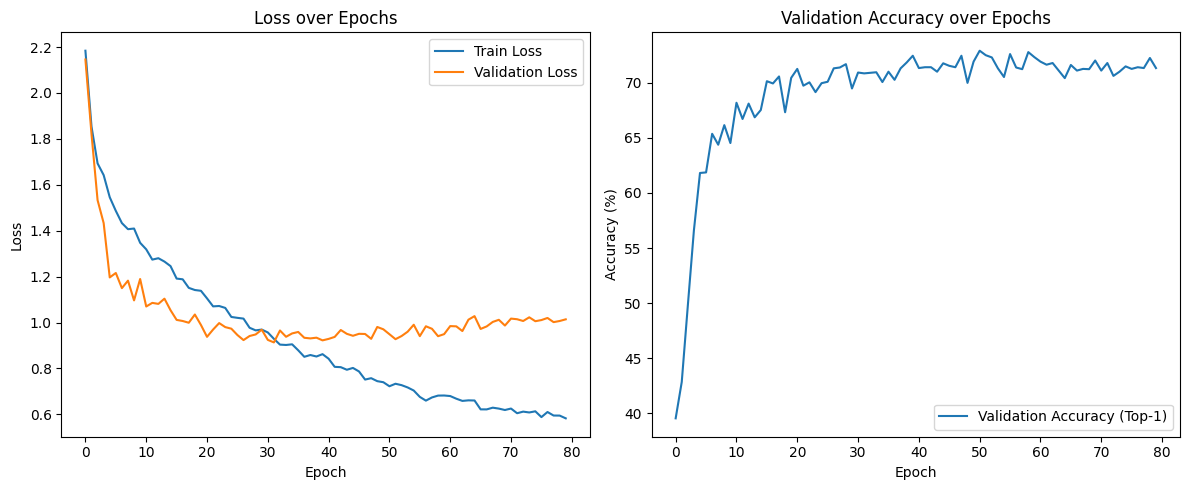

In [10]:
# Visualize accuracy and loss from metrics
import matplotlib.pyplot as plt

# Extract metrics
epochs = metrics['epoch']
train_loss = metrics['train_loss']
val_loss = metrics['test_loss']
val_acc = [m['top1'] if isinstance(m, dict) and 'top1' in m else m for m in metrics['test_metric']]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, val_acc, label='Validation Accuracy (Top-1)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
from datetime import datetime

# Export the trained model to ONNX format
#onnx_path = "kenyanfood_model.onnx"

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save the trained model's state_dict
model_save_path = f"kenyanfood_model_{timestamp}.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model state_dict saved to {model_save_path}")

Model state_dict saved to kenyanfood_model_20250622_160322.pth


## Inference on Test Set and Submission File Creation
Now we run inference on the test set and create a DataFrame with the image ids and predicted labels.

In [14]:
import pandas as pd
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch

from torchvision import transforms
import os

# Load test.csv
test_csv = pd.read_csv('./data/test.csv')
test_img_dir = './data/images/images'  # same as train

# Get class_to_idx mapping from training set
train_csv = pd.read_csv('./data/train.csv')
classes = sorted(train_csv.iloc[:, 1].unique())
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}

def test_transform(image):
    # Use the same resize as validation
    import albumentations
    resize = albumentations.Compose([
        albumentations.Resize(height=224, width=224)
    ])
    image = np.array(image)
    image = resize(image=image)['image']
    image = transforms.ToTensor()(image)
    return image

# Prepare test dataset
image_ids = test_csv.iloc[:, 0].tolist()
pred_labels = []

model.eval()
with torch.no_grad():
    for img_id in tqdm(image_ids, desc="Predicting test set"):
        img_name = str(img_id)
        if not img_name.lower().endswith('.jpg'):
            img_name += '.jpg'
        img_path = os.path.join(test_img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        image = test_transform(image)
        image = image.unsqueeze(0).to(trainer_config.device)
        output = model(image)
        pred_idx = output.argmax(dim=1).item()
        pred_label = idx_to_class[pred_idx]
        pred_labels.append(pred_label)

# Create DataFrame for submission
submission_df = pd.DataFrame({
    'id': image_ids,
    'label': pred_labels
})

# Save to CSV
submission_df.to_csv('submission.csv', index=False)
print('Saved predictions to submission.csv')

Predicting test set:   0%|          | 0/1638 [00:00<?, ?it/s]

Predicting test set: 100%|██████████| 1638/1638 [00:35<00:00, 46.75it/s]

Saved predictions to submission.csv
